# Importing Packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from scipy.stats import uniform, randint
from sklearn.exceptions import FitFailedWarning

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=FitFailedWarning)

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering


# Data Preprocessing

In [49]:
df = pd.read_csv(
    "data/chr_census_2010_2024_cleaned.csv",
    index_col=0,
    dtype={
        "geo_code": str,
        "state_fips": str,
        "year": int,
        "pop_quantiles_by_year": str,
        "income_quantiles_by_year": str,
    },
)


# Select columns
geo = df[
    [
        "geo_code",
        "year",
        "geo_full_name",
        "geo_name",
        "state",
        "state_code",
        "state_fips",
        "region",
        "division",
        "income_quantiles_by_year",
        "pop_quantiles_by_year",
    ]
]
numeric_df = df.select_dtypes(include=[np.number])
X = numeric_df.drop(columns=["life_expectancy", "year"], axis=1)
y = df["life_expectancy"]

# Preprocessing for numeric data
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),  # Standardization step added here
    ]
)

# Bundle preprocessing for numerical data
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, X.columns)])

# Modeling

## Linear Regression

In [34]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the pipeline
model_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

# Train the model
model_lr.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = model_lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"RMSE: {rmse_lr}")
print(f"R²: {r2_lr}")

RMSE: 1.1864973971802315
R²: 0.8267799447388954


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ridge_model = Ridge(random_state=42)
param_dist = {
    'alpha': uniform(0.1, 10)  # Test alpha values between 0.1 and 10
}
random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of random parameter combinations to try
    cv=5,       # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available cores for computation
)

model_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_search', random_search)
])
model_ridge.fit(X_train, y_train)

best_params_ridge = model_ridge.named_steps['random_search'].best_params_
print(f"Best hyperparameters: {best_params_ridge}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'alpha': 9.799098521619943}


In [37]:
# 11. Make predictions on the test set
y_pred_ridge = model_ridge.predict(X_test)

# 12. Evaluate the model
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"RMSE: {rmse_ridge}")
print(f"R²: {r2_ridge}")

RMSE: 1.1864829418386251
R²: 0.8267841654642416


## Random Forest Regressor with Feature Selection

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RMSE: {rmse_rf}")
print(f"R²: {r2_rf}")

RMSE: 0.9052046875470214
R²: 0.899177332939151


In [39]:
rf = model_rf.named_steps['regressor']  # Get the RandomForestRegressor part
importance_rf = rf.feature_importances_

rf_df = pd.DataFrame(zip(X.columns, importance_rf), columns=['feature', 'importance'])
rf_sorted = rf_df.sort_values(by='importance', ascending=False)
rf_sorted.head(20)

,feature,importance
31,premature_death,0.743348
8,driving_alone_to_work,0.023343
14,insufficient_sleep,0.022059
0,adult_obesity,0.015102
4,college_completion,0.014752
21,pct_65_and_older,0.012688
32,preventable_hospital_stays,0.009577
23,pct_female,0.008287
43,poor_health,0.007554
2,air_pollution_particulate_matter,0.007521


## Random Forest with RandomizedSearchCV

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': randint(100, 500),        # Number of trees
    'max_depth': randint(3, 20),              # Maximum depth of trees
    'min_samples_split': randint(2, 10),      # Minimum samples to split a node
    'min_samples_leaf': randint(1, 10),       # Minimum samples in a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider at each split
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings to sample
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Display progress
    random_state=42,
    n_jobs=-1  # Use all available cores
)

model_rf_rs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_search', random_search)
])

model_rf_rs.fit(X_train, y_train)

best_params = model_rf_rs.named_steps['random_search'].best_params_
print(f"Best hyperparameters: {best_params}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/datascisteven/miniconda3/envs/ml-env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan 0.83337244        nan 0.7481537  0.86079607 0.65964032
 0.86994121        nan 0.84597932 0.85566137 0.69562433 0.87380367
 0.84104262 0.77764253 0.70858252 0.85250574        nan        nan
        nan 0.85967561        nan 0.83606653        nan 0.78660417
 0.63884873        nan 0.81787716        nan        nan 0.77515447
 0.86191935 0.82468535 0.70606978 0.85842882        nan        nan
 0.82813315 0.64106978        nan 0.85873507        nan 0.8790604
        nan        nan 0.76569916        nan 0.86318906        nan
 0.76422196        nan]
  warnings.warn(


Best hyperparameters: {'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 153}


In [41]:
y_pred_rf_rs = model_rf_rs.predict(X_test)

rmse_rf_rs = np.sqrt(mean_squared_error(y_test, y_pred_rf_rs))
r2_rf_rs = r2_score(y_test, y_pred_rf_rs)

print(f"RMSE: {rmse_rf_rs}")
print(f"R²: {r2_rf_rs}")

RMSE: 0.9694838545828962
R²: 0.8843499686250519


## XGBoost Model with Feature Selection

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

model_xgb.fit(X_train, y_train)
2
y_pred_xgb = model_xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"RMSE: {rmse_xgb}")
print(f"R²: {r2_xgb}")

RMSE: 0.8962882772611271
R²: 0.9011537891998616


In [43]:
xgboost_model = model_xgb.named_steps['regressor']
importance = xgboost_model.feature_importances_

xgboost_df = pd.DataFrame(zip(X.columns, importance), columns=['feature', 'importance'])
xgboost_sorted = xgboost_df.sort_values(by='importance', ascending=False)
xgboost_sorted.head(20)

,feature,importance
31,premature_death,0.566476
14,insufficient_sleep,0.039574
8,driving_alone_to_work,0.028514
43,poor_health,0.022342
35,single_parent_households,0.019634
4,college_completion,0.018334
0,adult_obesity,0.016001
32,preventable_hospital_stays,0.014611
21,pct_65_and_older,0.014543
33,severe_housing_problems,0.014494


## XGBoost (Extremely Gradient Boosting) with RandomizedSearchCV

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgboost_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

param_dist = {
    'n_estimators': randint(100, 1000),        # Number of boosting rounds (trees)
    'max_depth': randint(3, 15),               # Maximum depth of each tree
    'learning_rate': uniform(0.01, 0.3),       # Learning rate (step size)
    'subsample': uniform(0.5, 1),              # Fraction of data to sample per tree
    'colsample_bytree': uniform(0.5, 1),       # Fraction of features used per tree
    'gamma': uniform(0, 5),                    # Minimum loss reduction for split
    'reg_alpha': uniform(0, 1),                # L1 regularization term
    'reg_lambda': uniform(1, 10)               # L2 regularization term
}

random_search = RandomizedSearchCV(
    estimator=xgboost_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings to sample
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Display progress
    random_state=42,
    n_jobs=-1  # Use all available cores
)

model_xgb_rs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_search', random_search)
])

model_xgb_rs.fit(X_train, y_train)
best_params = model_xgb_rs.named_steps['random_search'].best_params_
print(f"Best hyperparameters: {best_params}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/datascisteven/miniconda3/envs/ml-env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.90073679 0.91764997        nan 0.9154141         nan        nan
        nan        nan 0.90326804        nan        nan        nan
        nan 0.90342126        nan        nan 0.89544522        nan
        nan        nan 0.90208524        nan 0.90040531 0.90895302
        nan        nan 0.89310264        nan        nan 0.90558771
 0.89684103        nan        nan        nan        nan        nan
        nan        nan 0.89505084        nan 0.90501096        nan
        nan 0.87669811 0.89417156        nan 0.88936148 0.91086767
        nan        nan]
  warnings.warn(


Best hyperparameters: {'colsample_bytree': 0.8337086111390218, 'gamma': 0.7143340896097039, 'learning_rate': 0.20526654188465587, 'max_depth': 7, 'n_estimators': 869, 'reg_alpha': 0.7219987722668247, 'reg_lambda': 10.385527090157503, 'subsample': 0.5007787658410143}


In [45]:
y_pred_xgb_rs = model_xgb_rs.predict(X_test)

rmse_xgb_rs = np.sqrt(mean_squared_error(y_test, y_pred_xgb_rs))
r2_xgb_rs = r2_score(y_test, y_pred_xgb_rs)

print(f"RMSE: {rmse_xgb_rs}")
print(f"R²: {r2_xgb_rs}")

RMSE: 0.7587947366583885
R²: 0.9291543461809618


## Principal Component Analysis (PCA) Dimensionality Reduction

In [47]:
# Define preprocessing for numeric features (imputation + standardization + PCA)
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),  # Retain 95% of variance
    ]
)

# Preprocessor for the numeric data
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, X.columns)])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define Ridge regression model
ridge_model = Ridge(random_state=42)

# Hyperparameter distribution for RandomizedSearchCV
param_dist = {"alpha": uniform(0.1, 10)}  # Test alpha values between 0.1 and 10

# RandomizedSearchCV to tune Ridge hyperparameters
random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of random parameter combinations to try
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1,  # Use all available cores for computation
)

# Create the pipeline
model_ridge = Pipeline(
    steps=[("preprocessor", preprocessor), ("random_search", random_search)]
)

# Fit the model
model_ridge.fit(X_train, y_train)

# Extract and print the best hyperparameters
best_params_ridge = model_ridge.named_steps["random_search"].best_params_
print(f"Best hyperparameters: {best_params_ridge}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'alpha': 9.799098521619943}


In [48]:
# Make predictions and evaluate the model with the best parameters
y_pred_ridge = model_ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"RMSE: {rmse_ridge}")
print(f"R²: {r2_ridge}")

RMSE: 1.2629754501950006
R²: 0.8037297793509952


In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Standardize the data
scaler = StandardScaler().fit(X)   # Fit the scaler on X
X_sc = scaler.transform(X)         # Transform X using the fitted scaler

# 2. Apply PCA
pca = PCA(n_components=50)          # Specify the number of principal components to retain
principalComponents = pca.fit_transform(X_sc)

# 3. Eigenvalues and Eigenvectors
eig_values = pca.explained_variance_  # Eigenvalues
eig_vectors = pca.components_         # Eigenvectors (principal components)

# 4. Extract individual eigenvectors (principal components)
eig_vec1 = eig_vectors[0]   # First principal component
eig_vec2 = eig_vectors[1]   # Second principal component
eig_vec3 = eig_vectors[2]   # Third principal component
eig_vec4 = eig_vectors[3]   # Fourth principal component
eig_vec5 = eig_vectors[4]
eig_vec6 = eig_vectors[5]

# 5. Calculate loadings for the first principal component
loading_1 = eig_vec1 * np.sqrt(eig_values[0])  # Loadings for the first component

# 6. Create a Pandas Series to display the scores (loadings) for the first component
scores_1 = pd.Series(loading_1, index=X.columns.to_list())

# 7. Sort loadings to understand feature contributions
scores_1.sort_values(ascending=False)

ValueError: n_components=50 must be between 0 and min(n_samples, n_features)=44 with svd_solver='full'

In [142]:
# 5. Calculate loadings for the first principal component
loading_2 = eig_vec2 * np.sqrt(eig_values[1])  # Loadings for the first component

# 6. Create a Pandas Series to display the scores (loadings) for the first component
scores_2 = pd.Series(loading_2, index=X.columns.to_list())

# 7. Sort loadings to understand feature contributions
scores_2.sort_values(ascending=False)

severe_housing_problems                                0.771073
sexually_transmitted_infections                        0.568945
pct_asian                                              0.551268
pct_professional_management_and_scientific_services    0.546843
pct_aapi                                               0.538238
                                                         ...   
pct_nat_res_constr_maint_occupations                  -0.487633
median_age                                            -0.523865
pct_non_hispanic_white                                -0.648263
pct_rural                                             -0.702056
homeownership                                         -0.724628
Length: 92, dtype: float64

In [143]:
# 5. Calculate loadings for the first principal component
loading_3 = eig_vec3 * np.sqrt(eig_values[2])  # Loadings for the first component

# 6. Create a Pandas Series to display the scores (loadings) for the first component
scores_3 = pd.Series(loading_3, index=X.columns.to_list())

# 7. Sort loadings to understand feature contributions
scores_3.sort_values(ascending=False)

preventable_hospital_stays                0.600638
injury_deaths                             0.455137
poor_mental_health_days                   0.445602
mental_health_providers                   0.445188
frequent_mental_distress                  0.431956
                                            ...   
severe_housing_cost_burden               -0.511310
pct_sales_and_office_occupations         -0.513687
pct_households_with_high_housing_costs   -0.539666
mammography_screening                    -0.673880
air_pollution_particulate_matter         -0.689458
Length: 92, dtype: float64

In [144]:
loading_4 = eig_vec4 * np.sqrt(eig_values[3])
scores_4 = pd.Series(loading_4, index=X.columns.to_list())
scores_4.sort_values(ascending=False)

pct_agriculture_hunting_and_mining      0.639141
pct_nat_res_constr_maint_occupations    0.539382
uninsured_adults                        0.518257
limited_access_to_healthy_foods         0.493026
pct_hispanic                            0.423773
                                          ...   
preventable_hospital_stays             -0.368107
insufficient_sleep                     -0.402216
poor_mental_health_days                -0.453453
pct_manufacturing                      -0.477728
driving_alone_to_work                  -0.531917
Length: 92, dtype: float64

In [145]:
loading_5 = eig_vec5 * np.sqrt(eig_values[4])
scores_5 = pd.Series(loading_5, index=X.columns.to_list())
scores_5.sort_values(ascending=False)

pct_under_18                              0.545757
pct_not_proficient_in_english             0.511568
pct_hispanic                              0.501006
pct_prod_transp_mat_moving_occupations    0.367156
median_household_income                   0.305684
                                            ...   
pct_non_hispanic_white                   -0.303967
mammography_screening                    -0.312578
pct_service_occupations                  -0.321829
pct_65_and_older                         -0.484321
median_age                               -0.506176
Length: 92, dtype: float64

In [146]:
loading_6 = eig_vec6 * np.sqrt(eig_values[5])
scores_6 = pd.Series(loading_6, index=X.columns.to_list())
scores_6.sort_values(ascending=False)

pct_under_18                              0.372683
social_associations                       0.354599
pct_manufacturing                         0.303268
pct_educational_and_health_services       0.292998
mammography_screening                     0.273253
                                            ...   
median_age                               -0.384463
pct_households_with_high_housing_costs   -0.390435
severe_housing_cost_burden               -0.401294
long_commute_driving_alone               -0.435722
pct_construction                         -0.494098
Length: 92, dtype: float64

In [147]:
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio: {explained_variance_ratio}")

Explained variance ratio: [0.17731265 0.10217106 0.06520792 0.05530231 0.04103171 0.03341579
 0.02755654 0.02441509 0.02133254 0.01954624 0.01707587 0.01652778]


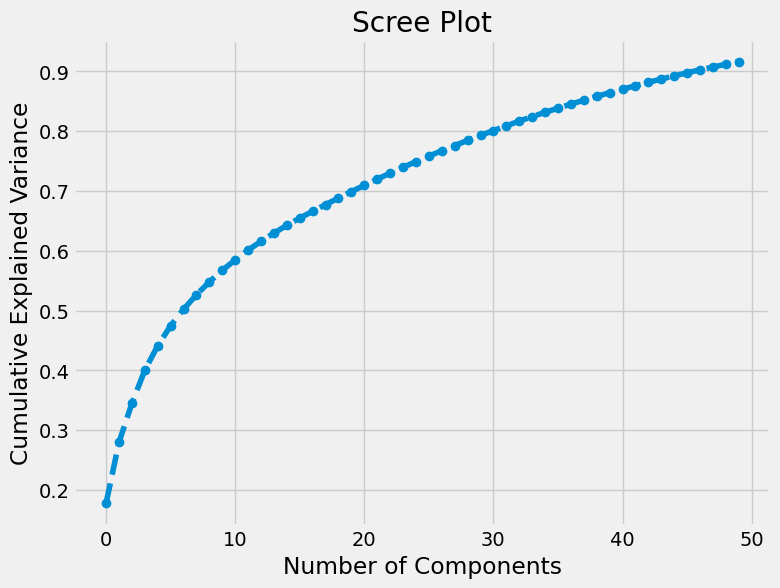

In [156]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

## LightGBM (Light Gradient Boosting Machine) Model

In [52]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_model = lgb.LGBMRegressor(random_state=42)

param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'num_leaves': randint(20, 50),
    'max_depth': randint(3, 15),
    'subsample': uniform(0.5, 1),
    'colsample_bytree': uniform(0.5, 1),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(1, 10)
}

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

model_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Assuming preprocessing from earlier
    ('random_search', random_search)
])

model_lgb.fit(X_train, y_train)
print(f"Best hyperparameters: {model_lgb.named_steps['random_search'].best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/datascisteven/miniconda3/envs/ml-env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the test scores are non-finite: [0.91511105        nan 0.90481529        nan 0.91347802        nan
 0.91142044        nan        nan        nan        nan        nan
        nan        nan 0.92017016 0.90578118        nan        nan
 0.89144804 0.92566259        nan        nan 0.8560593         nan
        nan        nan 0.91913401        nan 0.91979207        nan
        nan        nan        nan 0.8986839         nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.92105366        nan        nan        nan        nan
        nan        nan]
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 37715, number of used features: 44
[LightGBM] [Info] Start training from score 77.250999
Best hyperparameters: {'colsample_bytree': 0.804781258158029, 'learning_rate': 0.05939675594288252, 'max_depth': 13, 'n_estimators': 748, 'num_leaves': 49, 'reg_alpha': 0.22210781047073025, 'reg_lambda': 2.1986536733368283, 'subsample': 0.837615171403628}


In [53]:
y_pred_lgb = model_lgb.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"RMSE: {rmse_lgb}")
print(f"R²: {r2_lgb}")

RMSE: 0.7539263028401499
R²: 0.9300605225048356


## Support Vector Regression (SVR) Model

(takes a long time to run)

In [55]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the SVR model
svr_model = svm.SVR()

# Define the hyperparameter grid
param_dist = {
    'C': uniform(0.1, 10),           # Regularization parameter
    'epsilon': uniform(0.01, 1),      # Epsilon-insensitive loss function
    'kernel': ['linear', 'poly', 'rbf'],  # Kernel function
    'degree': randint(2, 5)           # Degree for 'poly' kernel
}

# RandomizedSearchCV for SVR
random_search = RandomizedSearchCV(
    estimator=svr_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Pipeline for preprocessing and SVR
model_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_search', random_search)
])

# Fit the model
model_svm.fit(X_train, y_train)

# Best parameters
print(f"Best hyperparameters: {model_svm.named_steps['random_search'].best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'C': 9.968869366005173, 'degree': 2, 'epsilon': 0.20871568153417241, 'kernel': 'rbf'}


In [56]:
# Make predictions and evaluate the model
y_pred_svm = model_svm.predict(X_test)
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
r2_svm = r2_score(y_test, y_pred_svm)
print(f"RMSE: {rmse_svm}")
print(f"R²: {r2_svm}")

RMSE: 0.7908231575828343
R²: 0.9230473908503274


## MLP (Multi-Layer Perceptron) Regressor

In [64]:
from sklearn.neural_network import MLPRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the MLPRegressor model
mlp_model = MLPRegressor(random_state=42, max_iter=1000)

# Define the hyperparameter grid
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50,100)],  # Layer sizes
    'activation': ['relu', 'tanh'],                               # Activation function
    'solver': ['adam', 'sgd'],                                    # Optimization algorithm
    'alpha': uniform(0.0001, 0.1),                                # Regularization term
    'learning_rate': ['constant', 'adaptive']
}

# RandomizedSearchCV for MLPRegressor
random_search = RandomizedSearchCV(
    estimator=mlp_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Pipeline for preprocessing and MLP
model_mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_search', random_search)
])

# Fit the model
model_mlp.fit(X_train, y_train)

# Best parameters
print(f"Best hyperparameters: {model_mlp.named_steps['random_search'].best_params_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: inva

[CV] END activation=relu, alpha=0.059785015794648705, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   2.3s
[CV] END activation=relu, alpha=0.059785015794648705, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   2.3s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: inva

[CV] END activation=relu, alpha=0.059785015794648705, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   2.5s
[CV] END activation=relu, alpha=0.059785015794648705, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   2.6s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.059785015794648705, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.6s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.04602488919658672, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  49.8s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.04602488919658672, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  50.0s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.04602488919658672, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  51.0s
[CV] END activation=relu, alpha=0.04602488919658672, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  51.4s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.04602488919658672, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  50.1s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0797542986860233, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.3min
[CV] END activation=relu, alpha=0.0797542986860233, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.3min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0797542986860233, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.3min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0797542986860233, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.3min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0797542986860233, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.3min
[CV] END activation=tanh, alpha=0.09395527090157503, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   7.1s
[CV] END activation=relu, alpha=0.06184815096277166, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.9s
[CV] END activation=relu, alpha=0.06184815096277166, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.0s
[CV] END activation=relu, alpha=0.06184815096277166, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.2s
[CV] END activation=relu, alpha=0.06184815096277166, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   2.2s
[CV] END activation=relu, alpha=0.06184815096277166, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   1.9s
[CV] END activation=tanh, alpha=0.002406242504141

/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.06518884729488529, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  57.6s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.06518884729488529, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  58.3s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.06518884729488529, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  57.2s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.06518884729488529, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  58.7s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.06518884729488529, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  58.6s
[CV] END activation=tanh, alpha=0.0024062425041415756, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   6.7s
[CV] END activation=tanh, alpha=0.0024062425041415756, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   8.9s
[CV] END activation=tanh, alpha=0.0024062425041415756, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   8.2s
[CV] END activation=tanh, alpha=0.0024062425041415756, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   9.7s
[CV] END activation=tanh, alpha=0.004766566321361543, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive, solver=adam; total time=  11.4s
[CV] END activation=tanh, alpha=0.004766566321361543, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive, solver=adam; total time=  15.8s
[CV] END activat

/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.09842308858067883, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   1.9s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.09842308858067883, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.1s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.00916064345328208, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   8.6s
[CV] END activation=tanh, alpha=0.00916064345328208, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  20.5s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.09395527090157503, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.5min
[CV] END activation=tanh, alpha=0.09395527090157503, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.6min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.09395527090157503, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.5min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.09395527090157503, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.6min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid v

[CV] END activation=relu, alpha=0.06813075385877798, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  49.8s
[CV] END activation=relu, alpha=0.06813075385877798, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  50.1s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.06813075385877798, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  49.5s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.06813075385877798, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  49.5s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.06813075385877798, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  53.0s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.00916064345328208, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time= 1.7min
[CV] END activation=tanh, alpha=0.09432017556848528, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.0min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.09432017556848528, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.6min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.09432017556848528, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.5min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_stochastic_optimizers.py:184: RuntimeWarning: invalid value encountered in subtract
  self.momentum * velocity - self.learning_rate * grad
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  w

[CV] END activation=tanh, alpha=0.09432017556848528, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.7min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.09432017556848528, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.7min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0016966252220214195, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.4min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.0016966252220214195, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.4min
[CV] END activation=relu, alpha=0.0016966252220214195, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.4min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimizatio

[CV] END activation=relu, alpha=0.0016966252220214195, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.4min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0016966252220214195, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.3min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.017436465350777208, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  48.4s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.017436465350777208, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  48.8s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.017436465350777208, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  48.1s
[CV] END activation=tanh, alpha=0.07563614103176526, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   6.4s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.017436465350777208, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  48.0s
[CV] END activation=tanh, alpha=0.07563614103176526, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=  21.1s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.017436465350777208, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  47.8s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.056870032781999154, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  59.8s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.056870032781999154, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  59.8s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.06842635188254582, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=sgd; total time= 2.8min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.07563614103176526, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.6min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.07563614103176526, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.6min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.06842635188254582, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=sgd; total time= 2.8min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.07563614103176526, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.6min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.06842635188254582, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=sgd; total time= 2.8min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.06842635188254582, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=sgd; total time= 2.8min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.06842635188254582, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=sgd; total time= 2.9min
[CV] END activation=tanh, alpha=0.0728271995856421, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  13.3s
[CV] END activation=tanh, alpha=0.0728271995856421, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  21.3s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.056870032781999154, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  59.0s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.056870032781999154, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  57.2s
[CV] END activation=relu, alpha=0.05218342600258237, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.3s
[CV] END activation=tanh, alpha=0.0728271995856421, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   8.5s
[CV] END activation=tanh, alpha=0.04507541333697657, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=  38.8s
[CV] END activation=relu, alpha=0.05218342600258237, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   2.2s
[CV] END activation=tanh, alpha=0.056870032781999154, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  58.2s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0728271995856421, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  18.3s
[CV] END activation=relu, alpha=0.05218342600258237, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.8s
[CV] END activation=relu, alpha=0.05218342600258237, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   1.9s
[CV] END activation=tanh, alpha=0.0748320110137381, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   2.2s
[CV] END activation=relu, alpha=0.05218342600258237, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   2.9s
[CV] END activation=tanh, alpha=0.0728271995856421, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=  16.3s
[CV] END activation=tanh, alpha=0.0748320110137381, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   3.0s
[CV] END activation=tanh, alpha=0.07483201101373

/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.02972735057040824, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.6s
[CV] END activation=tanh, alpha=0.0748320110137381, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  25.6s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: inva

[CV] END activation=tanh, alpha=0.0966255307264138, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive, solver=adam; total time=  19.4s
[CV] END activation=tanh, alpha=0.0748320110137381, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  37.6s
[CV] END activation=tanh, alpha=0.0966255307264138, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive, solver=adam; total time=  21.7s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.04507541333697657, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.6min
[CV] END activation=tanh, alpha=0.0015079822715084457, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   2.9s
[CV] END activation=tanh, alpha=0.0015079822715084457, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   5.3s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.04507541333697657, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.6min
[CV] END activation=tanh, alpha=0.0015079822715084457, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   2.4s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.0015079822715084457, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   6.3s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/mi

[CV] END activation=tanh, alpha=0.04507541333697657, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.6min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.04507541333697657, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.6min
[CV] END activation=tanh, alpha=0.0015079822715084457, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  15.9s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.042440148070636965, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  53.3s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.042440148070636965, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  52.8s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.042440148070636965, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  53.4s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.042440148070636965, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  51.4s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.042440148070636965, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=  51.6s
[CV] END activation=relu, alpha=0.06520770255019445, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=adam; total time=  12.3s
[CV] END activation=relu, alpha=0.06520770255019445, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=adam; total time=  10.4s
[CV] END activation=tanh, alpha=0.04504506741382035, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   7.3s
[CV] END activation=relu, alpha=0.06520770255019445, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=adam; total time=  22.9s
[CV] END activation=relu, alpha=0.06520770255019445, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=adam; total time=  22.5s
[CV] END activation=relu, alpha=0.06520770255019445, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=adam; total time=  14.4s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.04504506741382035, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   9.6s
[CV] END activation=tanh, alpha=0.04504506741382035, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   8.2s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: inva

[CV] END activation=tanh, alpha=0.04504506741382035, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   8.2s
[CV] END activation=tanh, alpha=0.04504506741382035, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   7.3s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.07911755405312057, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.3min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.07911755405312057, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.4min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.07911755405312057, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.3min
[CV] END activation=tanh, alpha=0.027572179299006416, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   6.5s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.07911755405312057, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.3min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.07911755405312057, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.3min
[CV] END activation=relu, alpha=0.09727120953891039, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   3.2s
[CV] END activation=tanh, alpha=0.027572179299006416, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   9.9s
[CV] END activation=relu, alpha=0.09727120953891039, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   1.4s
[CV] END activation=tanh, alpha=0.027572179299006416, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=  10.3s
[CV] END activation=tanh, alpha=0.027572179299006416, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=  10.0s
[CV] END activation=tanh, alpha=0.027572179299006416, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   9.4s
[CV] END activation=relu, alpha

/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.06698412526636073, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  51.1s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.06698412526636073, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  50.9s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.06698412526636073, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  51.6s
[CV] END activation=tanh, alpha=0.023698491974895576, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  13.9s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimizatio

[CV] END activation=relu, alpha=0.06698412526636073, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  50.1s
[CV] END activation=relu, alpha=0.06698412526636073, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  50.0s
[CV] END activation=tanh, alpha=0.023698491974895576, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  14.1s
[CV] END activation=tanh, alpha=0.023698491974895576, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  13.6s
[CV] END activation=tanh, alpha=0.023698491974895576, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  16.0s
[CV] END activation=tanh, alpha=0.023698491974895576, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  18.5s
[CV] END activation=relu, alpha=0.02027192023353962, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=adam; total time=   4.3s
[CV] END activation=relu, alpha=0.020271

/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/mi

[CV] END activation=relu, alpha=0.07116628896857874, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.3min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_stochastic_optimizers.py:184: RuntimeWarning: invalid value encountered in subtract
  self.momentum * velocity - self.learnin

[CV] END activation=relu, alpha=0.07116628896857874, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.3min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimizatio

[CV] END activation=relu, alpha=0.07116628896857874, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.3min
[CV] END activation=relu, alpha=0.07116628896857874, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.3min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.07116628896857874, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.3min
[CV] END activation=tanh, alpha=0.08814678390152578, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  44.1s
[CV] END activation=tanh, alpha=0.04175099478703663, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.04175099478703663, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=  11.0s
[CV] END activation=tanh, alpha=0.08814678390152578, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time= 1.3min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.08814678390152578, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time= 1.6min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.08814678390152578, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time= 1.6min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.04175099478703663, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time= 1.5min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.04175099478703663, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time= 1.5min
[CV] END activation=tanh, alpha=0.012308795470067335, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  56.0s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.012308795470067335, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  54.9s
[CV] END activation=relu, alpha=0.027313224938463533, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   3.1s
[CV] END activation=relu, alpha=0.027313224938463533, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   1.4s
[CV] END activation=relu, alpha=0.027313224938463533, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   2.7s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.04175099478703663, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time= 1.5min
[CV] END activation=relu, alpha=0.027313224938463533, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   2.0s
[CV] END activation=tanh, alpha=0.03535688563341691, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   1.6s
[CV] END activation=relu, alpha=0.027313224938463533, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   2.8s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.012308795470067335, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  56.2s
[CV] END activation=tanh, alpha=0.03535688563341691, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  13.5s
[CV] END activation=tanh, alpha=0.03535688563341691, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  15.8s
[CV] END activation=tanh, alpha=0.03535688563341691, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   2.7s
[CV] END activation=tanh, alpha=0.03535688563341691, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.1s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.010649425983027061, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive, solver=sgd; total time= 2.7min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.010649425983027061, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive, solver=sgd; total time= 2.7min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.010649425983027061, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive, solver=sgd; total time= 2.7min
[CV] END activation=relu, alpha=0.010649425983027061, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive, solver=sgd; total time= 2.7min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.010649425983027061, hidden_layer_sizes=(100, 50, 100), learning_rate=adaptive, solver=sgd; total time= 2.7min
[CV] END activation=tanh, alpha=0.0535089419375442, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  12.4s
[CV] END activation=tanh, alpha=0.0535089419375442, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  12.3s
[CV] END activation=tanh, alpha=0.0535089419375442, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  11.9s
[CV] END activation=tanh, alpha=0.0535089419375442, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  14.4s
[CV] END activation=tanh, alpha=0.021976421957307025, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=sgd; total time=   3.3s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.012308795470067335, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  55.7s
[CV] END activation=tanh, alpha=0.0535089419375442, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=  12.2s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.012308795470067335, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=  56.0s
[CV] END activation=relu, alpha=0.027041233379852148, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=adam; total time=   9.9s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.021976421957307025, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=sgd; total time=   5.2s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.021976421957307025, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=sgd; total time=   4.3s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.021976421957307025, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=sgd; total time=   6.7s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=relu, alpha=0.027041233379852148, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=adam; total time=  15.8s
[CV] END activation=relu, alpha=0.027041233379852148, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=adam; total time=  12.0s
[CV] END activation=tanh, alpha=0.021976421957307025, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=sgd; total time=  11.9s
[CV] END activation=relu, alpha=0.027041233379852148, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=adam; total time=  19.3s
[CV] END activation=relu, alpha=0.027041233379852148, hidden_layer_sizes=(100, 50, 100), learning_rate=constant, solver=adam; total time=  24.0s
[CV] END activation=tanh, alpha=0.06973042728397884, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   8.0s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.06973042728397884, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   8.4s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.06973042728397884, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   6.4s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.06973042728397884, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   6.5s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


[CV] END activation=tanh, alpha=0.06973042728397884, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   9.1s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.006589224710898157, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.2min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.006589224710898157, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.2min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.006589224710898157, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.2min
[CV] END activation=tanh, alpha=0.041203701331823134, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   2.6s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.006589224710898157, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.2min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.006589224710898157, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time= 1.2min
[CV] END activation=tanh, alpha=0.041203701331823134, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  11.6s
[CV] END activation=tanh, alpha=0.041203701331823134, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  12.3s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.09987404850489419, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.2min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.09987404850489419, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.2min
[CV] END activation=tanh, alpha=0.041203701331823134, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  13.4s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.09987404850489419, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.2min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.09987404850489419, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.2min


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.09987404850489419, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time= 1.2min
[CV] END activation=tanh, alpha=0.041203701331823134, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=  25.4s


/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
55 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/examsherpa/miniconda3/envs/tf-env/lib/python3.8/site-packages/sklearn/neura

Best hyperparameters: {'activation': 'tanh', 'alpha': 0.0966255307264138, 'hidden_layer_sizes': (100, 50, 100), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [65]:
# Make predictions and evaluate the model
y_pred_mlp = model_mlp.predict(X_test)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
r2_mlp = r2_score(y_test, y_pred_mlp)
print(f"RMSE: {rmse_mlp}")
print(f"R²: {r2_mlp}")

RMSE: 2.0269209708298157
R²: 0.49448013648995015


## Stacking Regressor

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold

# Set up the base models
base_models = [
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('lr', LinearRegression())
]

# Define the meta-model (could be another XGBoost or any regressor)
meta_model = XGBRegressor(n_estimators=50, random_state=42)

# Create the StackingRegressor
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Apply K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate using cross-validation
cross_val_scores = cross_val_score(stacked_model, X, y, cv=kfold, scoring='neg_mean_squared_error')

# Calculate mean RMSE
rmse_scores = (-cross_val_scores) ** 0.5
mean_rmse = rmse_scores.mean()

print(f'Cross-validated RMSE: {mean_rmse}')

Cross-validated RMSE: 0.7806287704794131


## LSTM

In [120]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [158]:
data = pd.read_csv('chr_census_2010_2024.csv', index_col=0, dtype={"geo_code": str, "year": int})
data = data.drop(columns=["geo_full_name", "geo_name", "state", "state_code"])
data.head()

,geo_code,year,access_to_exercise_opportunities,adult_obesity,adult_smoking,air_pollution_particulate_matter,alcohol_impaired_driving_deaths,children_eligible_for_free_lunch,children_in_poverty,children_in_single_parent_households,...,severe_housing_cost_burden,severe_housing_problems,sexually_transmitted_infections,single_parent_households,social_associations,some_college,teen_births,unemployment_rate,uninsured_adults,violent_crime
0,01001,2010,0.6907,0.300,0.2814,12.5700,0.284338,0.161946,0.1380,0.2954,...,0.144260,0.096612,370.0,0.179785,13.455842,0.501062,47.513321,0.062076,0.140,256.487012
1,01003,2010,0.6523,0.245,0.2309,11.5998,0.321341,0.204360,0.1933,0.2852,...,0.174773,0.116501,245.9,0.138206,11.480511,0.576810,31.854171,0.065605,0.209,171.623233
2,01005,2010,0.3645,0.364,0.2268,12.0202,0.404637,0.362199,0.3410,0.5196,...,0.171885,0.158040,585.7,0.225625,8.042733,0.364850,87.486157,0.095894,0.151,64.005310
3,01007,2010,0.3021,0.317,0.2746,11.6488,0.275008,0.161418,0.2420,0.3549,...,0.116541,0.066255,284.0,0.187878,9.764098,0.322305,30.716724,0.091338,0.177,127.580788
4,01009,2010,0.2168,0.315,0.2342,12.5406,0.190252,0.201278,0.1850,0.2530,...,0.152476,0.068867,85.1,0.142587,8.418282,0.382355,36.640361,0.075270,0.208,93.782854


In [159]:
# Step 1: Normalize features
scalers = {}
for county in data['geo_code'].unique():
    scaler = MinMaxScaler(feature_range=(0, 1))
    county_data = data[data['geo_code'] == county].drop(columns=['geo_code', 'year'])
    scaled_data = scaler.fit_transform(county_data)
    scalers[county] = scaler
    data.loc[data['geo_code'] == county, county_data.columns] = scaled_data

In [160]:
# Step 2: Function to create sequences for each county
def create_county_sequences(data, look_back=1):
    X, Y = [], []
    for county in data['geo_code'].unique():
        county_data = data[data['geo_code'] == county].drop(columns=['geo_code', 'year'])
        county_life_expectancy = data[data['geo_code'] == county]['life_expectancy'].values
        for i in range(len(county_data) - look_back):
            X.append(county_data.iloc[i:(i + look_back)].values)
            Y.append(county_life_expectancy[i + look_back])
    return np.array(X), np.array(Y)

look_back = 5

X, y = create_county_sequences(data, look_back)

In [163]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Build the LSTM model
model = Sequential()

# Add LSTM layer (you can experiment with the number of neurons)
model.add(LSTM(50, return_sequences=False, input_shape=(look_back, X_train.shape[2])))

# Add Dense layer for the output (1 node for regression output)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100


2024-09-16 12:43:52.166758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-16 12:43:52.297329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-16 12:43:52.405005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


786/786 - 8s - loss: 0.0439 - 8s/epoch - 10ms/step
Epoch 2/100
786/786 - 5s - loss: 0.0332 - 5s/epoch - 6ms/step
Epoch 3/100
786/786 - 5s - loss: 0.0311 - 5s/epoch - 6ms/step
Epoch 4/100
786/786 - 5s - loss: 0.0300 - 5s/epoch - 6ms/step
Epoch 5/100
786/786 - 5s - loss: 0.0284 - 5s/epoch - 6ms/step
Epoch 6/100
786/786 - 5s - loss: 0.0273 - 5s/epoch - 7ms/step
Epoch 7/100
786/786 - 5s - loss: 0.0262 - 5s/epoch - 6ms/step
Epoch 8/100
786/786 - 5s - loss: 0.0253 - 5s/epoch - 6ms/step
Epoch 9/100
786/786 - 5s - loss: 0.0243 - 5s/epoch - 6ms/step
Epoch 10/100
786/786 - 5s - loss: 0.0236 - 5s/epoch - 6ms/step
Epoch 11/100
786/786 - 5s - loss: 0.0227 - 5s/epoch - 7ms/step
Epoch 12/100
786/786 - 5s - loss: 0.0220 - 5s/epoch - 7ms/step
Epoch 13/100
786/786 - 5s - loss: 0.0214 - 5s/epoch - 7ms/step
Epoch 14/100
786/786 - 5s - loss: 0.0207 - 5s/epoch - 6ms/step
Epoch 15/100
786/786 - 5s - loss: 0.0202 - 5s/epoch - 6ms/step
Epoch 16/100
786/786 - 5s - loss: 0.0194 - 5s/epoch - 7ms/step
Epoch 17/100

In [164]:
# Step 7: Make predictions
y_pred_lstm = model.predict(X_test)

# Inverse transform the predictions for each county (scale back to original scale)
inverse_predictions = []
for i in range(len(X_test)):
    county = data['geo_code'].unique()[i // (len(data) // len(data['geo_code'].unique()))]  # Get the corresponding county
    scaler = scalers[county]
    pred = scaler.inverse_transform(y_pred_lstm[i].reshape(1, -1))
    inverse_predictions.append(pred[0, 0])

# Convert predictions to numpy array
y_pred_rescaled_lstm = np.array(inverse_predictions)

# Step 8: Evaluate the model using RMSE
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_rescaled_lstm))
r2_lstm = r2_score(y_test, y_pred_rescaled_lstm)
print(f"Test RMSE: {rmse_lstm}")
print(f"Test R2: {r2_lstm}")

 21/197 [==>...........................] - ETA: 0s 

2024-09-16 12:52:17.091964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-16 12:52:17.138476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


197/197 [==============================] - 1s 6ms/step


ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,93)

In [ ]:
# Optional: Plot the predictions vs actual
import matplotlib.pyplot as plt
plt.plot(y_test, label='Actual Life Expectancy')
plt.plot(y_pred_rescaled_lstm, label='Predicted Life Expectancy')
plt.legend()
plt.show()

In [170]:
model_list = ["Linear Regression",
              "Ridge Regression",
              "Random Forest Regressor",
              "Random Forest after Feature Selection",
              "Random Forest with RandomizedSearchCV",
              "XGBoost Regressor",
              "XGBoost after Feature Selection",
              "XGBoost with RandomizedSearchCV",
              "LightGBM Model",
              "MLP Regressor"]

rmse_list = [rmse_lr, 
             rmse_ridge, 
             rmse_rf, 
             rmse_rf_sub, 
             rmse_rf_rs, 
             rmse_xgb, 
             rmse_xgb_rs, 
             rmse_xgb_sub, 
             rmse_lgb, 
             rmse_mlp]

r2_list = [r2_lr,
           r2_ridge,
           r2_rf,
           r2_rf_sub,
           r2_rf_rs,
           r2_xgb,
           r2_xgb_sub,
           r2_xgb_rs,
           r2_lgb,
           r2_mlp]

pd.DataFrame(zip(model_list, rmse_list, r2_list), columns=['Model', 'RMSE', 'R^2'])

,Model,RMSE,R^2
0,Linear Regression,1.040492,0.866788
1,Ridge Regression,1.044288,0.865815
2,Random Forest Regressor,0.787206,0.923750
3,Random Forest after Feature Selection,0.900966,0.900119
4,Random Forest with RandomizedSearchCV,0.856640,0.909706
5,XGBoost Regressor,0.730875,0.934272
6,XGBoost after Feature Selection,0.693459,0.898747
7,XGBoost with RandomizedSearchCV,0.907133,0.940829
8,LightGBM Model,0.633560,0.950610
9,MLP Regressor,2.026921,0.494480
